## Investigate effective redshift distribution for spurious IA signal

In [40]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import locate
import time
import pyccl as ccl
import scipy.stats as st

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [41]:
cosmo = ccl.Cosmology(
    Omega_c=0.27,
    Omega_b=0.045,
    h=0.67,
    sigma8=0.8,
    n_s=0.96,
    Neff=3.04,
    m_nu=0.06,
    transfer_function='bbks',
    matter_power_spectrum='halofit',
)

In [4]:
# paths to required files
data_dir = '/home/b7009348/WGL_project/DES-data/'

lens_file = data_dir+'DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits'
#lens_file = data_dir+'DES_Y1A1_Lenses_z=0.75-0.9.fits'

source_Zs = data_dir+'mof_BPZ_(stacking).fits'
im3_file_full = data_dir+'y1_im3_shapes_matched.fits'
mcal_file_full = data_dir+'y1_mcal_shapes_matched.fits'


# im3_file_full = data_dir+'y1_im3_z=0-0.9.fits'
# mcal_file_full = data_dir+'y1_mcal_z=0-0.9.fits'

In [5]:
# load in im3 data 
with fits.open(im3_file_full) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    im3_weight = data['weight']
    im3_m = data['m']
del data

# load in mcal data
with fits.open(mcal_file_full) as hdu:
    data = hdu[1].data
    Ry = data['R11'] # this should be correct weighting now
del data

# load in z_mc for all sources
with fits.open(source_Zs) as hdu:
    data = hdu[1].data
    source_zmc = data['Z_MC']
    zmc_ID = data['COADD_OBJECTS_ID']
    
del data

# match z_mc values to source IDs
matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

# slice z_mc values to only to those in matched catalogue
source_zmc = source_zmc[zmc_indices]

# delete uneccessary arrays
del matches, zmc_indices, shape_indices, zmc_ID, im3_ID

In [6]:
print(np.shape(source_zmc))

(17814587,)


In [7]:
nbins = 1000

mcal_counts, mcal_bins = np.histogram(source_zmc, bins=nbins, weights=Ry)
im3_counts, im3_bins = np.histogram(source_zmc, bins=nbins, weights=im3_weight*(1+im3_m))
pure_counts, pure_bins = np.histogram(source_zmc, bins=nbins, weights=None)

mcal_freq = mcal_bins[:-1] * mcal_counts
print(sum(mcal_freq)/sum(mcal_counts))

im3_freq = im3_bins[:-1] * im3_counts
print(sum(im3_freq)/sum(im3_counts))

0.5831333596744828
0.566407948575109


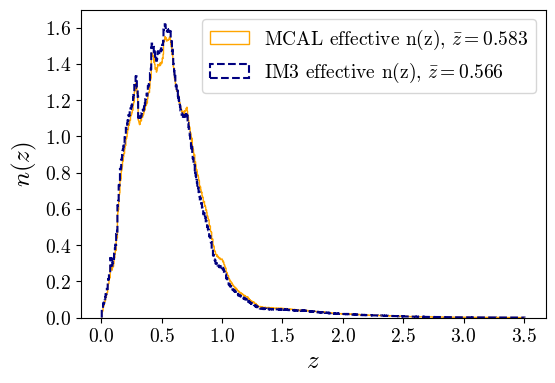

In [43]:
plt.figure(figsize=[6,4])
plt.hist(mcal_bins[:-1], mcal_bins, weights=mcal_counts, density=True, histtype='step', color='orange', linestyle='-', linewidth=1)
plt.hist(im3_bins[:-1], im3_bins, weights=im3_counts, density=True, histtype='step', color='navy', linestyle='--', linewidth=1.5)
plt.legend(labels=(r'MCAL effective n(z), $\bar{z}=0.583$', r'IM3 effective n(z), $\bar{z}=0.566$'),
           fontsize=14)
plt.xlabel(r'$z$', fontsize=18)
plt.ylabel(r'$n(z)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Matched catalogue sources')
plt.savefig('effective_n(z)_comparison.pdf', bbox_inches='tight', dpi=300)

## Run redshift distributions through CCL pipeline for theoretical $\gamma_{t}$
- Values for cosmology taken from

In [9]:
with fits.open(lens_file) as hdu:
    data = hdu[1].data
    lens_z = data['ZREDMAGIC']
    w_l = data['WEIGHT']
del data

lens_dndz, lens_bins = np.histogram(lens_z, bins=nbins, weights=w_l)

# Define cosmology

cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

mcal_z = mcal_bins[:-1]
mcal_dndz = mcal_counts

im3_z = im3_bins[:-1]
im3_dndz = im3_counts

pure_z = pure_bins[:-1]
pure_dndz = pure_counts

lens_z = lens_bins[:-1]

theta_range = np.logspace(np.log10(2.5), np.log10(250), 10)

b = 1.6*np.ones([nbins])

In [10]:
print(theta_range)

[  2.5          4.17025134   6.95639851  11.60397208  19.35659207
  32.28874163  53.86086725  89.8453416  149.87106258 250.        ]


In [11]:
lensTracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(lens_z, lens_dndz), bias=(lens_z, b))
im3Tracer = ccl.WeakLensingTracer(cosmo, dndz=(im3_z,im3_dndz))
mcalTracer = ccl.WeakLensingTracer(cosmo, dndz=(mcal_z,mcal_dndz))
pureTracer = ccl.WeakLensingTracer(cosmo, dndz=(pure_z, pure_dndz))

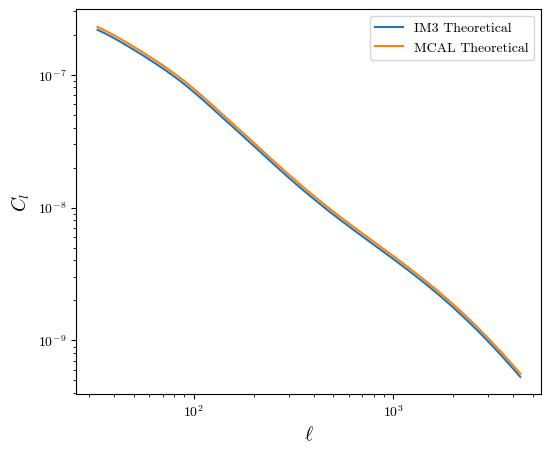

In [12]:
ell = np.unique(np.geomspace(180/(theta_range[-1]/60.) - 10, 180/(theta_range[0]/60.) + 10, 1024).astype(int))

im3_aps = ccl.angular_cl(cosmo, lensTracer, im3Tracer, ell, limber_integration_method='spline')
mcal_aps = ccl.angular_cl(cosmo, lensTracer, mcalTracer, ell, limber_integration_method='spline')
pure_aps = ccl.angular_cl(cosmo, lensTracer, pureTracer, ell, limber_integration_method='spline')

plt.figure(figsize=[6,5])
plt.plot(ell, im3_aps)
plt.plot(ell, mcal_aps)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{l}$', fontsize=14)
plt.xlabel(r'$\ell$', fontsize=14)
plt.legend(['IM3 Theoretical', 'MCAL Theoretical'])
plt.savefig('theoretical_APS.png', dpi=300)

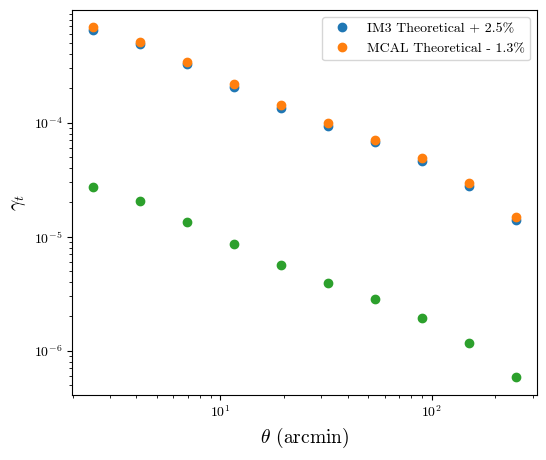

In [50]:
sig_mcal = 0.013
sig_im3 = 0.025

im3_gammat = ccl.correlation(cosmo, ell, im3_aps, theta_range / 60., type='NG')
mcal_gammat = ccl.correlation(cosmo, ell, mcal_aps, theta_range / 60., type='NG')
mbias_gammat = ccl.correlation(cosmo, ell, pure_aps, theta_range / 60., type='NG') * (sig_mcal + sig_im3)

plt.figure(figsize=[6,5])
plt.plot(theta_range, im3_gammat, linewidth=0, marker='o')
plt.plot(theta_range, mcal_gammat, linewidth=0, marker='o')
plt.plot(theta_range, mbias_gammat, linewidth=0, marker='o')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-6, 1e-2])
plt.ylabel(r'$\gamma_{t}$', fontsize=14)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.legend([r'IM3 Theoretical + 2.5%', 'MCAL Theoretical - 1.3%'])
plt.savefig('theoretical_gammat_multi_shift.png', dpi=300)

In [51]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

real_values = np.load(data_dir+'multiia_full-bin_slop=0.1.npz')
jackknife_values = np.load(data_dir+'multiia_jackknife-bin_slop=0.1.npz')

yT = real_values['IA']
cov_T = jackknife_values['IA_cov']

bar_mbias = mbias_gammat / (real_values['boost'] - 1 + real_values['F'])

weight_gammat = (im3_gammat - mcal_gammat) / (real_values['boost'] - 1 + real_values['F'])

selection = [1.72398501e-04, 1.17365656e-04, 7.99896844e-05, 5.47153881e-05,
 3.83130579e-05, 2.96587629e-05, 1.95784909e-05, 1.60777252e-05,
 1.26697805e-05, 9.00903309e-06]

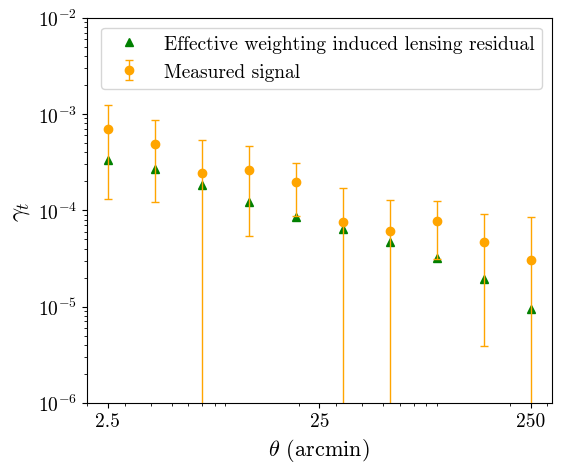

In [73]:
plt.figure(figsize=[6,5])
plt.plot(theta_range, -weight_gammat, linewidth=0, marker='^', color='green', markersize=6,
        label='Effective weighting induced lensing residual')
plt.errorbar(theta_range, yT, yerr=np.sqrt(np.diag(cov_T)), linewidth=0, marker='o', elinewidth=1, capsize=3, color='orange', 
             label='Measured signal')
#plt.plot(theta_range, yIA+weight_gammat, lw=0, marker='^', color='green', label=r'Weighted-$n(z)$-induced lensing residual')
plt.xscale('log')
plt.yscale('log')
plt.xticks([2.5,25,250],['2.5','25','250'],fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([1e-6, 1e-2])
#plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}(\theta)$', fontsize=16)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.ylabel(r'$\gamma_{t}$', fontsize=18)
#plt.title(r'All lenses, $m_{im3}=%g$, $m_{mcal}=%g$'%(sig_im3, -sig_mcal), fontsize=18)
# plt.legend([r'$\tilde{\omega}(z)n_(z)$ induced $\bar{\gamma}_{L,PA}$', r'$(1-a)\bar{\gamma}_{IA}(\theta)$'], 
#          fontsize=14)
plt.legend(fontsize=14)
plt.savefig('IA_vs_effN(z).pdf',bbox_inches='tight', dpi=300)


# plt.savefig('des_y1_measured_signal.pdf',bbox_inches='tight', dpi=300)

# plt.legend(fontsize=14)
# plt.savefig('IA_vs_spurious.png', bbox_inches='tight', dpi=300)

In [96]:
np.sqrt(yIA @ np.linalg.inv(cov_IA) @ yIA.T)

3.2232948139233417

## Multiplicative Bias Differences

In [120]:
real_values = np.load(data_dir+'ia_full_values-bin_slop=0.npz')
jackknife_values = np.load(data_dir+'ia_jackknife_values-bin_slop=0.npz')

sig_mcal = 0.013
sig_im3 = 0.025

mbias_diff_max = sig_mcal + sig_im3

mbias_diffs = np.linspace(0.0,mbias_diff_max,10)

spurious_signal = np.zeros([len(mbias_diffs),len(theta_range)])
for i in range(len(mbias_diffs)):
    im3_gammat = ccl.correlation(cosmo, ell, im3_aps, theta_range /60., type='NG') * (1+sig_im3)
    mcal_gammat = ccl.correlation(cosmo, ell, mcal_aps, theta_range /60., type='NG') * (1+(sig_im3-mbias_diffs[i]))
    
    spurious_signal[i,:] = (im3_gammat-mcal_gammat) / (real_values['boost'] - 1 + real_values['F'])
    
plt.figure(figsize=[8,7])
plt.plot(theta_range, spurious_signal[9,:], linewidth=0, marker='o', color='mediumvioletred')
plt.errorbar(theta_range, real_values['IA'], yerr=np.sqrt(np.diag(jackknife_values['IA_cov'])), linewidth=0, marker='o', elinewidth=1, capsize=3, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([1e-6, 1e-2])
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}$', fontsize=18)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=18)

ValueError: operands could not be broadcast together with shapes (10,) (20,) 

In [ ]:
print(real_values['boost']-1)
plt.plot(theta_range, real_values['boost']-1, linewidth=0, marker='^')
plt.xscale('log')
plt.yscale('log')